In [1]:
# Importe les modules
import numpy as np
import datetime
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

from scipy import stats

# Utilise un style personnalisé pour Matplotlib
plt.style.use('./mplstyle/projet-6.mplstyle')

<img src='./images/logo-lapage-sans-fond.png' width=240px />

# Analysez les ventes d'une librairie avec Python

Nous sommes consultant *Data Analyst*, rattaché au service Marketing chez Lapage qui est une grande librairie en ligne très réputée. Lapage était originellement une librairie physique avec plusieurs points de vente. Mais devant le succès de certains de ses produits et l’engouement de ses clients, elle a décidé depuis 2 ans d’ouvrir un site de vente en ligne. L’entreprise souhaite faire le point après deux ans d’exercice, et pouvoir analyser ses points forts, ses points faibles, les comportements clients, etc..

## Sommaire<a id='0'></a>

* [Préparation des données source](#1)
    * [Importation](#1-1)
    * [Type des données](#1-2)
    * [Enregistrements test](#1-3)
    * [Valeurs manquantes](#1-4)
    * [Doublons ids](#1-5)
    * [Cohérence des données](#1-6)
    * [Regroupement des bases](#1-7)
* [Indicateurs de vente](#2)
    * [Chiffres clés](#2-1)
    * [Evolution du chiffre d'affaires](#2-2)
    * [Moyenne mobile du chiffre d'affaires](#2-3)
    * [Zoom sur les références](#2-4)
    * [Zoom sur les clients](#2-5)
    * [Traffic](#2-6)
* [Analyse clients](#3)
    * [Genre et catégories des livres achetés](#3-1)
    * [Âge et montant total des achats, fréquence d’achat et taille du panier moyen](#3-2)
    * [Âge et catégories des livres achetés](#3-3)

## Préparation des données source<a id='1'></a>

Un traitement identique sera appliqué, si nécessaire, à chaque fichier CSV qui compose la base de données :
* chargement dans un *DataFrame* ;
* vérification de l'importation ;
* renommage des variables ;
* vérification du type des données ;
* suppression des variables inutiles ;
* vérification des valeurs manquantes et/ou des doublons.

Les *DataFrames* seront ensuite regroupés afin de mener les analyses demandées.

### Importation<a id='1-1'></a>

In [2]:
df_customers = pd.read_csv('./datasets/customers.csv')
df_products = pd.read_csv('./datasets/products.csv')
df_transactions = pd.read_csv('./datasets/transactions.csv')

dfs = ['df_customers', 'df_products', 'df_transactions']

In [3]:
df_customers.head(3)

,client_id,sex,birth
0,c_4410,f,1967
1,c_7839,f,1975
2,c_1699,f,1984


In [4]:
df_products.head(3)

,id_prod,price,categ
0,0_1421,19.99,0
1,0_1368,5.13,0
2,0_731,17.99,0


In [5]:
df_transactions.head(3)

,id_prod,date,session_id,client_id
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714


Il n'y a pas de variables inutiles à supprimer. Par contre, pour faciliter la compréhension, les noms de variables vont être renommés et vont être harmonisés.

In [6]:
df_customers = df_customers.rename(
    columns={'sex': 'gender', 'birth': 'birth_year'})

df_products = df_products.rename(
    columns={'id_prod': 'product_id', 'categ': 'category'})

df_transactions = df_transactions.rename(
    columns={'id_prod': 'product_id', 'date': 'transaction_date'})

Voyons les dimensions des jeux de données.

In [7]:
print(f'Dimensions des DataFrames :')
for df in dfs:
    print(f'- {df} : {eval(df).shape}')
del df

Dimensions des DataFrames :
- df_customers : (8623, 3)
- df_products : (3287, 3)
- df_transactions : (679532, 4)


### Type des données<a id='1-2'></a>

In [8]:
df_customers.dtypes

client_id     object
gender        object
birth_year     int64
dtype: object

"gender" est une variable qualitative qui a un nombre fini de valeurs, son type va être modifié en "category".

In [9]:
df_customers['gender'] = df_customers['gender'].astype('category')

In [10]:
df_products.dtypes

product_id     object
price         float64
category        int64
dtype: object

"category" est aussi une variable qualitative dont il faut modifier le type.

In [11]:
df_products['category'] = df_products['category'].astype('category')

In [12]:
df_transactions.dtypes

product_id          object
transaction_date    object
session_id          object
client_id           object
dtype: object

Ici, seule la date n'est pas dans le bon format.

In [13]:
try:
    df_transactions['transaction_date'] = pd.to_datetime(
        df_transactions['transaction_date'])
except ValueError as erreur:
    print(erreur)

Unknown string format: test_2021-03-01 02:30:02.237419 present at position 3019


La conversion a échoué car la ligne 3019 contient la mention "test_" avant la date. Voyons si d'autres lignes sont concernées.

In [14]:
df_transactions.loc[df_transactions['transaction_date'].str.contains('test')]

,product_id,transaction_date,session_id,client_id
3019,T_0,test_2021-03-01 02:30:02.237419,s_0,ct_0
5138,T_0,test_2021-03-01 02:30:02.237425,s_0,ct_0
9668,T_0,test_2021-03-01 02:30:02.237437,s_0,ct_1
10728,T_0,test_2021-03-01 02:30:02.237436,s_0,ct_0
15292,T_0,test_2021-03-01 02:30:02.237430,s_0,ct_0
...,...,...,...,...
657830,T_0,test_2021-03-01 02:30:02.237417,s_0,ct_0
662081,T_0,test_2021-03-01 02:30:02.237427,s_0,ct_1
670680,T_0,test_2021-03-01 02:30:02.237449,s_0,ct_1
671647,T_0,test_2021-03-01 02:30:02.237424,s_0,ct_1


200 lignes correspondent à des tests. Il est nécessaire de les supprimer pour pouvoir convertir les dates de transaction dans le bon format.<br>
&#9888; Pour ne pas fausser les futures analyses il faudra également vérifier si on retrouve un ou des produit(s) test ("T_") et un ou des clients test ("ct_") dans les *DataFrames* concernés.

In [15]:
# Supprime les lignes de test
df_transactions = (
    df_transactions.loc[
        ~df_transactions['transaction_date'].str.contains('test')]
    .reset_index(drop=True)
)

# Convertit "transaction_date" dans le bon type
df_transactions['transaction_date'] = pd.to_datetime(
    df_transactions['transaction_date'])

### Enregistrements test<a id='1-3'></a>

Plusieurs transactions correspondent à des tests et on a constaté que c'est sûrement le cas pour les produits et les clients. C'est ce que l'on va vérifier maintenant.

In [16]:
df_products.loc[df_products['product_id'].str.contains('T')]

,product_id,price,category
731,T_0,-1.0,0


In [17]:
df_customers.loc[df_customers['client_id'].str.contains('ct')]

,client_id,gender,birth_year
2735,ct_0,f,2001
8494,ct_1,m,2001


On trouve bien un produit test, un client test féminin et un client test masculin. On les supprime.

In [18]:
df_products = (
    df_products.loc[~df_products['product_id'].str.contains('T')]
    .reset_index(drop=True)
)

df_customers = (
    df_customers.loc[~df_customers['client_id'].str.contains('ct')]
    .reset_index(drop=True)
)

### Valeurs manquantes<a id='1-4'></a>

In [19]:
print('Nombre de valeurs manquantes :')
for df in dfs:
    print(f'- {df} : {eval(df).isna().sum().sum()}')
del df

Nombre de valeurs manquantes :
- df_customers : 0
- df_products : 0
- df_transactions : 0


Tous les jeux de données sont complets.

### Doublons ids<a id='1-5'></a>

In [20]:
print(f'Nombre de doublons :')
for df in dfs:
    print(f'- {df} : {eval(df).duplicated().sum()}')
del df

Nombre de doublons :
- df_customers : 0
- df_products : 0
- df_transactions : 0


Il n'y a pas de doublons.

### Cohérence des données<a id='1-6'></a>

* Le genre des clients est-il toujours soit "f", soit "m" ?

In [21]:
genders = df_customers['gender'].unique().tolist()
print(f'Les différentes valeurs de "gender" sont : {genders}.')
del genders

Les différentes valeurs de "gender" sont : ['f', 'm'].


* Les années de naissances des clients sont-elles cohérentes ?

In [22]:
df_customers['birth_year'].sort_values().unique()

array([1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004],
      dtype=int64)

Les valeurs sont comprises entre 1929 et 2004 et il n'y a que des années composées de quatre chiffres.

* Les catégories des produits sont-elles en nombre limité et y-a-t'il des valeurs qui semblent incohérentes ?

In [23]:
categories = df_products['category'].unique().tolist()
print(f'Les différentes catégories sont : {categories}.')
del categories

Les différentes catégories sont : [0, 1, 2].


* Les prix des produits sont-ils tous supérieurs à 0 ?

In [24]:
test_price = (df_products['price'] <= 0).any()
print(f'Tous les prix sont supérieurs à 0 : {~test_price}.')
del test_price

Tous les prix sont supérieurs à 0 : True.


* Les transactions sont-elles enregistrées sur des années qui correspondent à la date d'ouverture du site en ligne ?

In [25]:
df_transactions['transaction_date'].dt.year.value_counts().sort_index()

2021    278335
2022    346500
2023     54497
Name: transaction_date, dtype: int64

Le site a ouvert il y a deux ans et il y a des transactions sur trois années. Vérifions qu'il n'y a bien que deux ans d'enregistrements.

In [26]:
first_date = df_transactions['transaction_date'].min()
last_date = df_transactions['transaction_date'].max()
print(f'Date du premier enregistrement : {first_date}.\n'
      f'Date du dernier enregistrement : {last_date}.')
del first_date, last_date

Date du premier enregistrement : 2021-03-01 00:01:07.843138.
Date du dernier enregistrement : 2023-02-28 23:58:30.792755.


Le site n'a pas été mis en ligne au mois de janvier de la première année ce qui explique que trois années apparaissent dans les données.

### Regroupement des bases<a id='1-7'></a>

On ajoute aux transactions les informations concernant les produits et les clients dans un nouveau *DataFrame* appelé `df_final`.

In [27]:
# Ajoute les informations produits
df_final = pd.merge((df_transactions), (df_products),
                    on=['product_id'], how='left')

# Ajoute les informations clients
df_final = pd.merge((df_final), (df_customers),
                    on=['client_id'], how='left')

df_final.head(3)

,product_id,transaction_date,session_id,client_id,price,category,gender,birth_year
0,0_1518,2022-05-20 13:21:29.043970,s_211425,c_103,4.18,0,f,1986
1,1_251,2022-02-02 07:55:19.149409,s_158752,c_8534,15.99,1,m,1988
2,0_1277,2022-06-18 15:44:33.155329,s_225667,c_6714,7.99,0,f,1968


Les données semblent correctes, vérifions la taille du nouveau jeu de données.

In [28]:
print(f'Dimensions de "df_final" : {df_final.shape}')

Dimensions de "df_final" : (679332, 8)


Le nombre de lignes est bon. `df_transactions` avait 679532 enregistrements desquels nous avons supprimé 200 lignes de test.<br>
Pour faciliter la lecture, on réorganise l'ordre des colonnes.

In [29]:
df_final = df_final[
    ['session_id', 'transaction_date', 'product_id','category',
     'price', 'client_id', 'gender', 'birth_year',]
]

En fin, vérifions si il y a des valeurs manquantes.

In [30]:
df_final.isna().sum()

session_id            0
transaction_date      0
product_id            0
category            221
price               221
client_id             0
gender                0
birth_year            0
dtype: int64

221 enregistrements n'ont ni prix, ni catégorie mais combien de produits sont concernés ?

In [31]:
# Calcule le nombre de produits sans prix/catégorie
products_na = df_final['product_id'].isna().nunique()
products_sum = df_final['product_id'].nunique()
print(f'Il y a {products_na} produit(s) non renseigné(s) sur {products_sum}.')

# Calcule le pourcentage de transactions incluant ces produits.
pct_transactions_na = (
    df_final.isna().any(axis='columns').sum()
    / len(df_final.index)
)
print(f'Cela représente {pct_transactions_na:.3%} des transactions.')

del products_na, products_sum, pct_transactions_na

Il y a 1 produit(s) non renseigné(s) sur 3266.
Cela représente 0.033% des transactions.


Supprimer ces lignes n'aura donc pas d'impact sur les analyses.

In [32]:
df_final = df_final.dropna(axis='rows', how='any').reset_index(drop=True)

Le jeu de données final est prêt. Les *DataFrames* sources ne sont plus utiles.

In [33]:
del df_products, df_customers, df_transactions, dfs

## Indicateurs de vente<a id='2'></a>

Pour réaliser les analyses de chiffre d'affaires, il faut regrouper les données par date mais selon différentes fréquences. Pour éviter de devoir manipuler à chaque fois le *DataFrame*, on crée une fonction que l'on va pouvoir appeler dès que nécessaire. Elle va retourner un *DataFrame* groupé utilisable pour le calcul des indicateurs et le traçage des graphiques.

In [34]:
def time_grouped_df(freq, start_date='2021-03-01', end_date='2023-02-28',
                    cat=[0, 1, 2], detail=False):
    """
    Groupe le DataFrame "df_final" selon la fréquence (année, mois, etc.)
    voulue en pouvant préciser la date de début, la date de fin et la ou les
    catégorie(s) des produits.
    Paramètres :
    - freq : la fréquence de regroupement.
    - start_date : la date de début de la période.
    - end_date : la date de fin de la période.
    - cat : la ou les catégorie(s) des produits.
    - detail : regroupe les prix par fréquence avec le détail par catégorie(s).
    """
    df = df_final.copy()
    if detail == False:
        df_grouped = (
            (
                df.loc[
                    (df['transaction_date'].dt.normalize() >= start_date)
                    & (df['transaction_date'].dt.normalize() <= end_date)
                    & (df['category'].isin(cat))
                ].sort_values('transaction_date')
            )
            .groupby(pd.Grouper(key='transaction_date', freq=freq))['price']
            .sum()
            .reset_index()
        )

    elif detail == True:
        df_grouped = (
            (
                df.loc[
                    (df['transaction_date'].dt.normalize() >= start_date)
                    & (df['transaction_date'].dt.normalize() <= end_date)
                    & (df['category'].isin(cat))
                ].sort_values('transaction_date')
            )
            .groupby(
            [pd.Grouper(key='transaction_date', freq=freq), 'category'])['price']
            .sum()
            .reset_index()
        )

    return df_grouped

### Chiffres clés<a id='2-1'></a>

Pour commencer, quelques chiffres d'ordre général :
* le résultat par années ;
* différents indicateurs mensuels.

In [35]:
# Affiche le chiffre d'affaires par années et le total
df = df_final[['transaction_date', 'price']].copy()
df['transaction_date'] = df['transaction_date'].dt.year
df = df.groupby('transaction_date').sum()

years = df.index
turnovers = round(df['price'] / 1000, 2)
total_turnover = round(df['price'].sum() / 1000, 2)

print(f'Chiffre d\'affaires annuel :')

for year, turnover in zip(years, turnovers):
    print(f'- {year} :  {turnover:>12} k€')

print(f'- Total : {total_turnover:>12} k€')

del df, years, turnovers, total_turnover, year, turnover

Chiffre d'affaires annuel :
- 2021 :       4770.83 k€
- 2022 :       6108.68 k€
- 2023 :        974.22 k€
- Total :     11853.73 k€


In [36]:
# Affiche les indicateurs de chiffre d'affaires mensuel
df = time_grouped_df(freq='MS')

metrics = ['Minimum', 'Maximum', 'Moyen', 'Médian']
values = [df['price'].min() / 1000, df['price'].max() / 1000,
            df['price'].mean() / 1000, df['price'].median() / 1000]

print(f'Chiffre d\'affaires mensuel :')

for metric, value in zip(metrics, values):
    print(f'- {metric} :\t{value:.2f} k€')

del df, metrics, values, metric, value

Chiffre d'affaires mensuel :
- Minimum :	320.80 k€
- Maximum :	535.57 k€
- Moyen :	493.91 k€
- Médian :	501.57 k€


Alors que le maximum, la moyenne et la médiane sont très proches, le minimum est assez éloigné. Il faudra examiner en détail les chiffres mensuels pour en trouver la raison.

### Evolution du chiffre d'affaires<a id='2-2'></a>

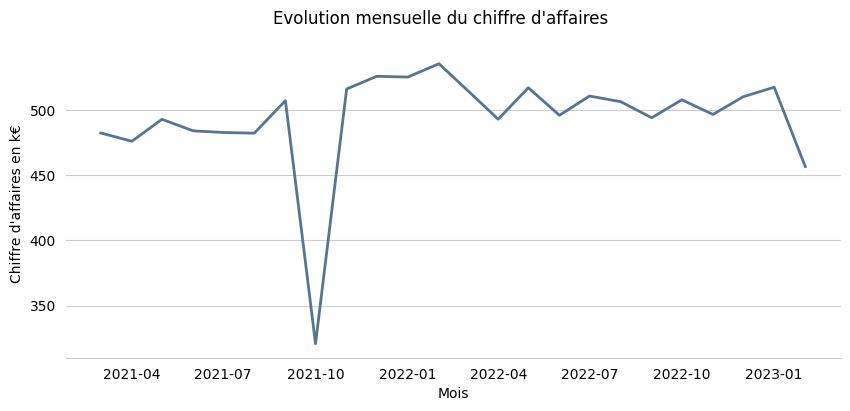

In [37]:
df = time_grouped_df(freq='MS')

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_xlabel('Mois')

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: format(int(x / 1000))))
ax.set_ylabel('Chiffre d\'affaires en k€')

ax.plot('transaction_date', 'price', data=df)

fig.suptitle('Evolution mensuelle du chiffre d\'affaires')

plt.show()

del df, fig, ax

Le chiffre réalisé au mois d'octobre 2021 dénote clairement. Nous allons en chercher la cause en rentrant dans le détail. Voyons ce que donne l'évolution du chiffre avec le détail par catégories.

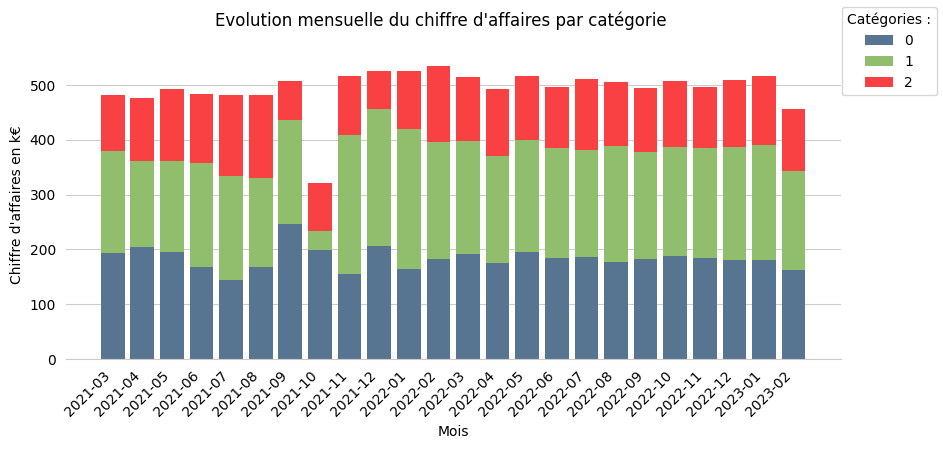

In [38]:
df = time_grouped_df(freq='MS', detail=True)

categories = df['category'].unique()
dates = df['transaction_date'].unique()
bar_position = np.arange(len(dates))
bar_bottom = np.zeros(len(dates))
bar_label = np.datetime_as_string(dates, unit='M')

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(bar_label, rotation=45, ha='right')
ax.set_xlabel('Mois')

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: format(int(x / 1000))))
ax.set_ylabel('Chiffre d\'affaires en k€')

for category in categories:
    values = df.loc[df['category'] == category, 'price']
    ax.bar(bar_position, values, bottom=bar_bottom, zorder=2)
    bar_bottom = np.add(bar_bottom, values).tolist()

fig.suptitle('Evolution mensuelle du chiffre d\'affaires par catégorie')
fig.legend(categories, title='Catégories :')

plt.show()

del (df, categories, dates, bar_position, bar_bottom, bar_label,
     fig, ax, category, values)

Il apparaît que c'est le chiffre réalisé pour la catégorie 1 qui est très faible comparé aux autres mois. Rentrons une nouvelle fois un peu plus dans le détail en traçant le chiffre réalisé pour chaque jour du mois d'octobre 2021 pour la catégorie 1.

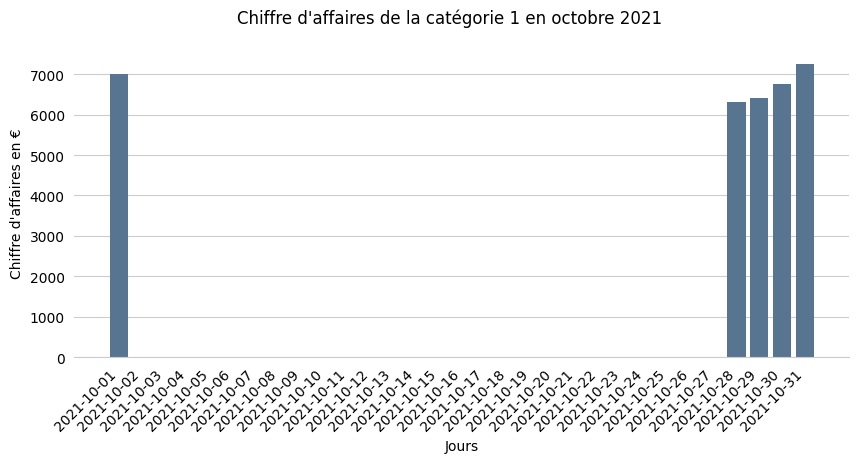

In [39]:
df = time_grouped_df(freq='D', start_date='2021-10-01',
                        end_date='2021-10-31', cat=[1])

dates = df['transaction_date'].unique()
values = df['price']
bar_position = np.arange(len(dates))
bar_label = np.datetime_as_string(dates, unit='D')

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_xticks(np.arange(len(dates)))
ax.set_xticklabels(bar_label, rotation=45, ha='right')
ax.set_xlabel('Jours')

ax.set_ylabel('Chiffre d\'affaires en €')

ax.bar(bar_position, values, zorder=2)

fig.suptitle('Chiffre d\'affaires de la catégorie 1 en octobre 2021')

plt.show()

del df, dates, values, bar_position, bar_label, fig, ax

La cause de l'écart s'explique donc par le fait que le chiffre d'affaires n'est enregistré que sur 5 jours. Soit il n'y a pas eu de ventes sur le site, soit il y eu un soucis technique et les chiffres ne sont pas remontés dans la base de données. La deuxième hypothèse est plus vraisemblable car il serait assez étrange qu'il n'y ait aucune vente sur une période aussi longue et seulement sur un mois en particulier.

### Moyenne mobile du chiffre d'affaires<a id='2-3'></a>

Pour apprécier la tendance globale de l'évolution du chiffre, nous traçons son évolution en moyenne mobile sur 3 mois.

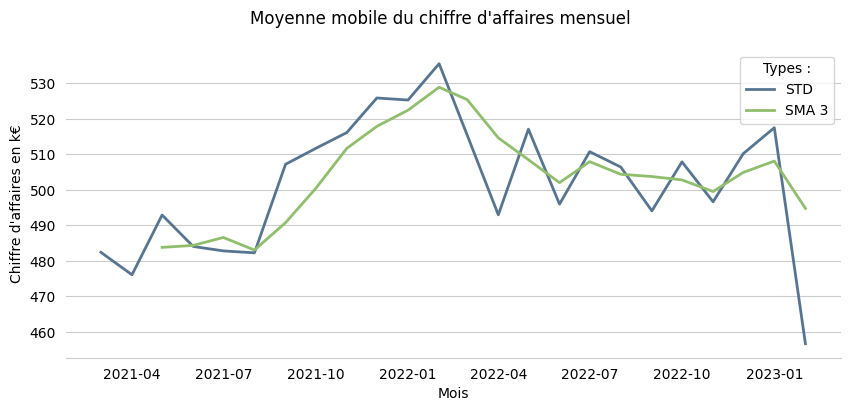

In [40]:
df = time_grouped_df(freq='MS')

window=3

df.loc[df['transaction_date'] == '2021-10-01', 'price'] = np.nan
df['price'] = df['price'].interpolate()

df['SMA'] = df['price'].rolling(window=window).mean()

fig, ax = plt.subplots(figsize=(10, 4))

ax.set_xlabel('Mois')

ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, pos: format(int(x / 1000))))
ax.set_ylabel('Chiffre d\'affaires en k€')

ax.plot('transaction_date', 'price', data=df, label='STD')
ax.plot('transaction_date', 'SMA', data=df, label=('SMA ' + str(window)))

ax.legend(title='Types :')

fig.suptitle('Moyenne mobile du chiffre d\'affaires mensuel')

plt.show()

del df, window, fig, ax

La moyenne mobile, en vert, montre une tendance du chiffre à la baisse après avoir connu un pic au début de 2022.

### Zoom sur les références<a id='2-4'></a>

L'analyse par produits va nécessiter de regrouper plusieurs fois les ventes par références. Comme pour le chiffre d'affaires, on crée donc une fonction de regroupement que l'on pourra appeler au besoin.

In [41]:
def product_grouped_df():
    """Groupe le DataFrame "df_final" par produits."""
    df = df_final.copy()
    df_grouped = (
        df.groupby(['category', 'product_id']).agg(
        {'product_id': 'count', 'price': 'sum'})
        .rename(columns={'product_id': 'quantity', 'price': 'turnover'})
        .reset_index()
    )
    
    # Conserve uniquement les lignes avec la bonne association catégorie/produit
    df_grouped = df_grouped.loc[
        df_grouped['product_id'].str[:1]
        == df_grouped['category'].astype('string')
    ]
    
    return df_grouped

#### Les top & les flops

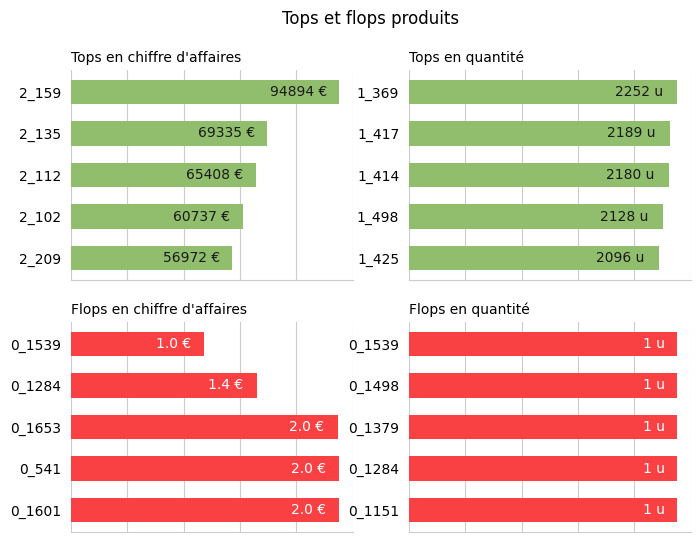

In [42]:
# Trace les tops et les flops produits en fonction du chiffre ou des quantités
df = product_grouped_df()

df_1 = df.nlargest(5, 'turnover').sort_values(by='turnover')
df_2 = df.nsmallest(5, 'turnover').sort_values(by='turnover', ascending=False)
df_3 = df.nlargest(5, 'quantity').sort_values(by='quantity')
df_4 = df.nsmallest(5, 'quantity').sort_values(by='quantity', ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(8, 6))

bar_1 = axs[0, 0].barh('product_id', 'turnover', data=df_1, zorder=2,
                       color='#90be6d', height=0.60)
bar_2 = axs[1, 0].barh('product_id', 'turnover', data=df_2, zorder=2,
                       color='#f94144', height=0.60)
bar_3 = axs[0, 1].barh('product_id', 'quantity', data=df_3, zorder=2,
                       color='#90be6d', height=0.60)
bar_4 = axs[1, 1].barh('product_id', 'quantity', data=df_4, zorder=2,
                       color='#f94144', height=0.60)

for i in range(len(axs)):
    for j in range(len(axs[0])):
        axs[i, j].grid(visible=None)
        axs[i, j].set(xticklabels=[])
        axs[i, j].xaxis.set_major_locator(ticker.LinearLocator(numticks=6))

axs[0, 0].bar_label(bar_1, fmt='{:.0f} €', padding=-50, color='0.1')
axs[1, 0].bar_label(bar_2, fmt='{:.1f} €', padding=-35, color='1.0')
axs[0, 1].bar_label(bar_3, fmt='{:.0f} u', padding=-45, color='0.1')
axs[1, 1].bar_label(bar_4, fmt='{:.0f} u', padding=-25, color='1.0')

fig.suptitle('Tops et flops produits')

axs[0, 0].set_title('Tops en chiffre d\'affaires', size=10, loc='left')
axs[1, 0].set_title('Flops en chiffre d\'affaires', size=10, loc='left')
axs[0, 1].set_title('Tops en quantité', size=10, loc='left')
axs[1, 1].set_title('Flops en quantité', size=10, loc='left')

plt.show()

del df, df_1, df_2, df_3, df_4, fig, axs, bar_1, bar_2, bar_3, bar_4, i, j

Les produits qui génèrent le plus de chiffre d'affaires ne sont pas les mêmes que ceux qui sont le plus vendus. Les produits vendus en plus grande quantités ne sont donc pas forcément les plus chers. Peu d'informations sont exploitables avec les flops. A priori, plusieurs références n'ont été vendues qu'une seule fois. Voyons la distribution du nombre de ventes.

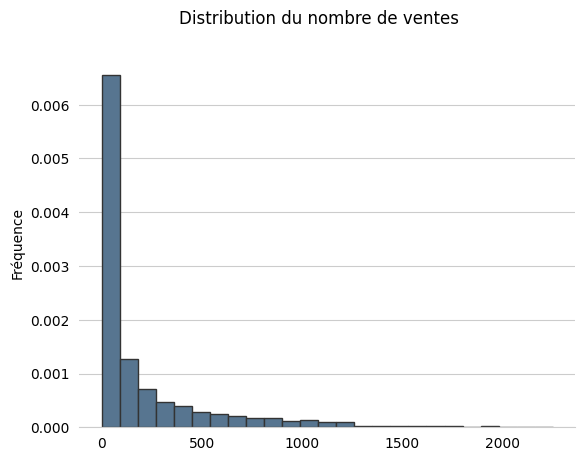

In [43]:
df = product_grouped_df()

fig, ax = plt.subplots()

ax.hist(df['quantity'], density=True, bins=25, zorder=2, edgecolor='0.2')
ax.set_ylabel('Fréquence')

fig.suptitle('Distribution du nombre de ventes')

plt.show()

del df, fig, ax

Une majorité de produits n'est vendu qu'un nombre assez faible de fois. Dans un objectif d'optimisation du nombre de références disponibles, il pourrait être intéressant de pousser les analyses sur ce point. On peut chercher aussi le nombre de produits ne se vendant pas du tout.

#### Répartition par catégorie

In [44]:
categories = df_final['category'].unique()

In [45]:
# Affiche le nombre de références dans chaque catégorie
df = (
    df_final[['category', 'product_id']]
    .groupby('category')['product_id']
    .nunique()
)

quantities = df.values

print(f'Nombre de références par catégorie : ')
for category, quantity in zip(categories, quantities):
    print(f'- Catégorie {category} : {quantity:>8}')
print(f'- Total :\t{(df.sum()):>8}')

del df, quantities, category, quantity

Nombre de références par catégorie : 
- Catégorie 0 :     2292
- Catégorie 1 :      737
- Catégorie 2 :      236
- Total :	    3265


La catégorie "0" comprend à elle seule la majorité des références. Voyons comment se répartissent les ventes des catégories.

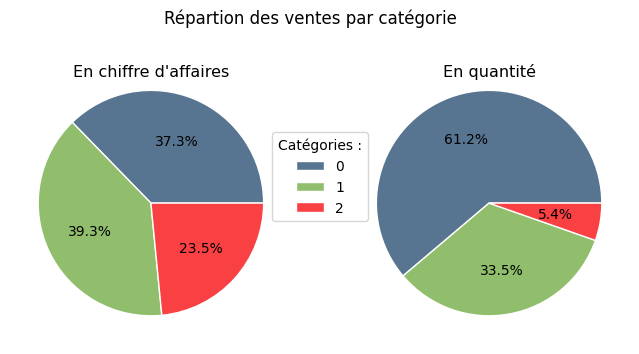

In [46]:
# Trace la répartition des ventes par catégories en chiffre et en quantité
df = product_grouped_df()

TO_sum = df.groupby('category')['turnover'].sum()
QTY_sum = df.groupby('category')['quantity'].sum()

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].pie(TO_sum, autopct='%.1f%%', wedgeprops={'edgecolor': '1.0'})
axs[0].set_title('En chiffre d\'affaires', y=0.92, size=11.5)
axs[1].pie(QTY_sum, autopct='%.1f%%', wedgeprops={'edgecolor': '1.0'})
axs[1].set_title('En quantité', y=0.92, size=11.5)

fig.suptitle('Répartion des ventes par catégorie')
fig.legend(categories, title='Catégories :', loc='center')

plt.show()

del df, TO_sum, QTY_sum, fig, axs

Les catégories "0" et "1" génèrent un chiffre d'affaires comparable tandis que la catégorie "2" est en deçà. La répartition des quantités est par contre très inégale. Il apparaît donc que les prix des produits des différentes catégories sont très inégaux. Pour en avoir une idée plus précise, on trace la distribution des prix par catégorie.

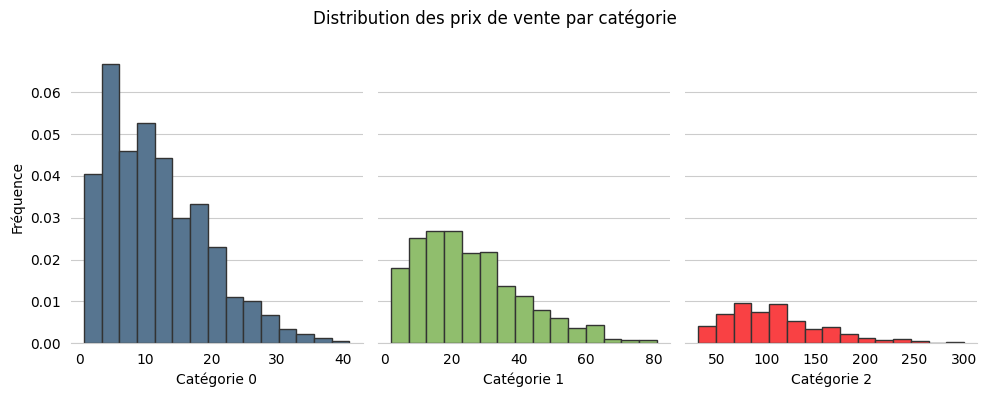

In [47]:
# Trace la distribution des prix de vente pour chaque catégorie
df = df_final.drop_duplicates(subset=['product_id'], keep='first')[
    ['product_id', 'category', 'price']]

fig, axs = plt.subplots(1, 3, figsize=(10, 4), sharey=True)

colors = ['#577590', '#90be6d', '#f94144']

for i in range(len(categories)):
    price_per_category = df.loc[df['category'] == i, :]

    axs[i].hist(price_per_category['price'], bins=15, zorder=2,
                edgecolor='0.2', density=True, color=colors[i])
    
    axs[i].set_xlabel('Catégorie ' + str(i))

axs[0].set_ylabel('Fréquence')

fig.suptitle('Distribution des prix de vente par catégorie')

plt.tight_layout()
plt.show()

del df, fig, axs, colors, i, price_per_category

La catégorie "0" est composée de produits à des prix en majorité autour de 10 €, la catégorie "1" est plutôt autour de 20 € et enfin, la catégorie "2" est composée de produits bien plus chers.

In [48]:
# Affiche quelques statistiques descriptives par catégorie
df = df_final.drop_duplicates(subset=['product_id'], keep='first')[
    ['product_id', 'category', 'price']]

display(df.groupby('category')['price'].describe().T)

del df

category,0,1,2
count,2292.000000,737.000000,236.000000
mean,11.714760,25.503623,107.636017
std,7.530238,15.435471,49.255576
min,0.620000,2.000000,30.990000
25%,5.627500,13.350000,70.690000
50%,10.305000,22.990000,101.250000
75%,16.475000,33.990000,134.945000
max,40.990000,80.990000,300.000000


On fait le même constat en analysant la moyenne et la médiane pour chaque catégorie.

In [49]:
del categories

### Zoom sur les clients<a id='2-5'></a>

Avant de démarrer les analyses, nous allons ajouter une nouvelle colonne au *DataFrame* avec l'âge des clients.

In [50]:
df_final['age'] = (datetime.date.today().year - df_final['birth_year'])

#### Classement clients

In [51]:
df_final.groupby('client_id')['price'].sum().nlargest(10)

client_id
c_1609    324033.35
c_4958    289760.34
c_6714    153598.92
c_3454    113637.93
c_3263      5276.87
c_1570      5271.62
c_2899      5214.05
c_2140      5208.82
c_7319      5155.77
c_7959      5085.45
Name: price, dtype: float64

In [52]:
df_final.groupby('client_id')['price'].sum().nsmallest(10)

client_id
c_8351     6.31
c_8140     8.30
c_8114     9.98
c_240     11.06
c_4648    11.20
c_4478    13.36
c_5962    13.99
c_6040    15.72
c_5919    15.98
c_5829    16.07
Name: price, dtype: float64

&#9888; Il y a un très grand écart de chiffre d'affaires entre les quatre plus gros clients et les suivants. On peut supposer que les clients en haut de classement ne sont pas des clients classiques. C'est à dire qu'au lieu d'être des particuliers on peut penser qu'ils correspondent à des professionnels. Il faudra garder cela en tête lors de l'analyse des comportements clients et nous allons déjà enregistrer leur identifiant.

In [53]:
# Stocke les clients pro dans une liste
pro_clients_id = list(
    df_final.groupby('client_id')['price'].sum().nlargest(4).index)

#### Profils clients

On cherche ici à savoir si les clients sont plutôt des femmes ou des hommes et si ils correspondent à une population jeune ou un peu plus âgée.

In [54]:
# Stocke les genres dans une liste
genders = list(df_final['gender'].unique())

In [55]:
# Affiche la répartition des clients en fonction du genre
df = df_final.drop_duplicates(subset=['client_id'], keep='first')[
    ['client_id', 'gender']]

values = df['gender'].value_counts(normalize=True).tolist()

print(f'Répartition par genre :')
for gender, value in zip(genders, values):
    print(f'- {gender} : {value:.1%}')

del df, values, gender, value

Répartition par genre :
- f : 52.1%
- m : 47.9%


Les femmes représentent la majorité des clients mais les deux genres sont en présents en proportions comparables.

In [56]:
# Affiche quelques statistiques descriptives par genre
df = df_final.drop_duplicates(subset=['client_id'], keep='first')[
    ['gender', 'age']]

display(df.groupby(['gender'])['age'].describe().T)

del df

gender,f,m
count,4479.000000,4121.000000
mean,45.027238,44.426353
std,17.091344,16.704484
min,19.000000,19.000000
25%,31.000000,31.000000
50%,44.000000,43.000000
75%,57.000000,57.000000
max,94.000000,94.000000


L'âge moyen et médian des femmes est légèrement supérieur à celui des hommes. Pour les deux sexes, les client les plus jeunes ont 19 ans et les plus âgés ont 94 ans.

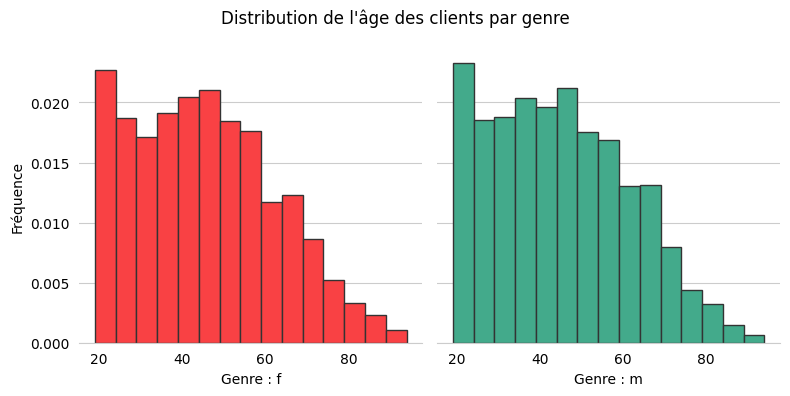

In [57]:
# Trace la distribution de l'âge pour chaque genre
df = df_final.drop_duplicates(subset=['client_id'], keep='first')[
    ['client_id', 'gender', 'age']]

fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

colors = ['#f94144', '#43aa8b']

for i, gender in enumerate(genders):
    client_per_gender = df.loc[df['gender'] == gender]
    axs[i].hist(client_per_gender['age'], density=True, bins=15,
                zorder=2, edgecolor='0.2', color=colors[i])
    axs[i].set_xlabel('Genre : ' + gender)

axs[0].set_ylabel('Fréquence')

fig.suptitle('Distribution de l\'âge des clients par genre')

plt.tight_layout()
plt.show()

del df, fig, axs, i, gender, client_per_gender

La distribution de l'âge est assez similaire pour les femmes et les hommes. Dans les deux cas, les clients les plus nombreux sont les plus jeunes, puis ceux ayant un peu plus de 40 ans. Cela correspond à la moyenne et la médiane calculées plus tôt.

#### Répartition du chiffre d'affaires

Pour terminer l'analyse, voyons si le chiffre d'affaires est réparti de manière égale entre les clients. Pour cela, on trace la courbe de Lorenz.

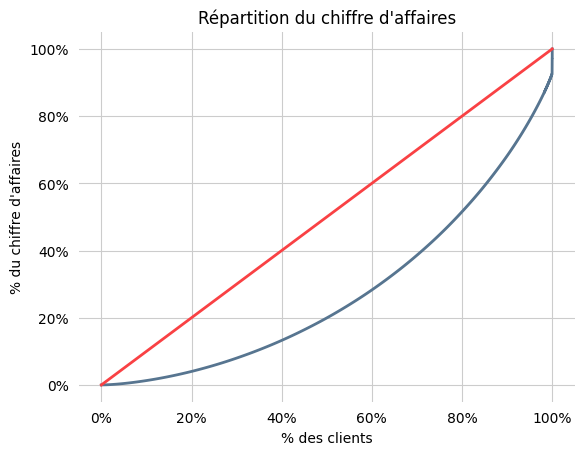

In [58]:
# Trace la courbe de Lorenz chiffre d'affaires/clients
df = df_final.groupby('client_id', as_index=False)['price'].sum()

turnover = df['price']
n_turnover = len(turnover)
cum_turnover = np.cumsum(np.sort(turnover)) / turnover.sum()
cum_turnover = np.append([0], cum_turnover)

cum_client = np.linspace(0-1/n_turnover, 1+1/n_turnover, len(cum_turnover))

fig, ax = plt.subplots()

ax.plot(cum_client, cum_turnover, drawstyle='steps-post')
ax.plot([0, 1], [0, 1], color='#f94144')

ax.grid(True)
ax.spines['bottom'].set_visible(False)
ax.xaxis.set_major_formatter(ticker.PercentFormatter(1))
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1))

ax.set_title('Répartition du chiffre d\'affaires')
ax.set_xlabel('% des clients')
ax.set_ylabel('% du chiffre d\'affaires')

plt.show()

del df, turnover, n_turnover, cum_turnover, cum_client, fig, ax

Une lecture que l'on peut faire du graphique est la suivante : 50 % des clients génèrent 20 % du chiffre d'affaires. On retrouve aussi à l'extrémité droite du graphique une zone où la courbe est complètement verticale. Il s'agit des clients professionnels.

### Traffic<a id='2-6'></a>

Le dernier indicateur qui va nous intéresser va être un aperçu du traffic. On fait le choix de comptabiliser le nombre de sessions total par jours et par heures depuis la mise en ligne du site internet.

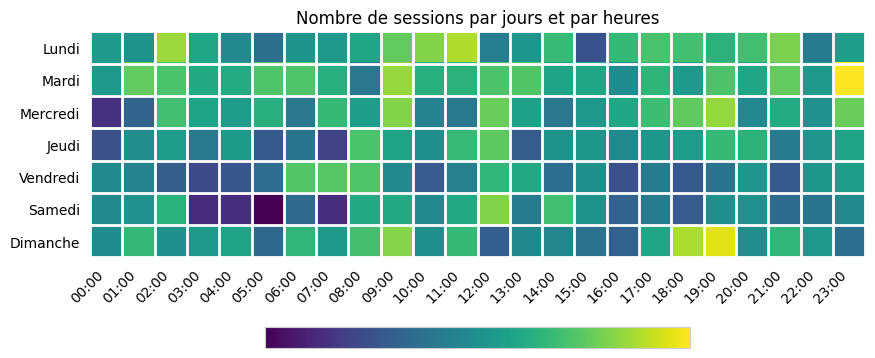

In [59]:
# Trace la heatmap du traffic par jours et par heures
df = df_final[['session_id', 'transaction_date']].copy()
df['transaction_day'] = df['transaction_date'].dt.dayofweek
df['transaction_hour'] = df['transaction_date'].dt.hour

df = df.groupby(['transaction_day', 'transaction_hour']
).agg({'session_id': 'count'}).reset_index()

df = pd.pivot_table(df, index='transaction_day',
                            columns='transaction_hour')

df.columns = df.columns.droplevel(0)

day_names = ['Lundi', 'Mardi', 'Mercredi', 'Jeudi', 'Vendredi',
                'Samedi', 'Dimanche']

hours = df.columns
hour_names = []
for hour in hours:
    hour_names.append(str(pd.to_timedelta(hour, unit='H'))[7:12])

fig, ax = plt.subplots(figsize=(10, 6))

im = ax.imshow(df, interpolation='nearest')

ax.set_xticks(np.arange(len(hour_names)))
ax.set_xticklabels(hour_names, rotation=45, ha='right')
ax.xaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax.set_yticks(np.arange(len(day_names)))
ax.set_yticklabels(day_names)
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))

ax.grid(visible=False, which='major', axis='both')
ax.grid(visible=True, which='minor', axis='both', color='1.0', linewidth=2)
ax.spines[['top', 'bottom', 'left', 'right']].set_visible(False)

ax.set_title('Nombre de sessions par jours et par heures')

cb = fig.colorbar(im, location='bottom', shrink=0.6, fraction=0.046)
cb.set_ticks([])

plt.show()

del df, day_names, hours, hour_names, hour, fig, ax, im, cb

On constate, par exemple, que le samedi en fin d'après-midi est une période assez importante pour les ventes. On observe également un pic d'activité un peu plus étonnant le mardi à 23 h. Peut-être les commandes d'un des clients pro ?

## Analyse clients<a id='3'></a>

Dans cette dernière partie, l'objectif est de vérifier l'existence de corrélations entre le profil des clients et leur comportement. Les tests seront réalisés en trois parties en fonction du type des variables étudiées :
1. Le lien entre le genre d’un client et les catégories des livres achetés (*qualitative/qualitative*).
1. Le lien entre l’âge des clients et le montant total des achats, la fréquence d’achat et la taille du panier moyen (*quantitative/quantitatives*).
1. Le lien entre l’âge des clients et les catégories des livres achetés (*quantitative/qualitative*).

En fin, rappelons-nous que les clients les plus importants (que l'on considère comme professionnels) devront être retirés du jeu de données avant de procéder aux tests afin qu'ils n'impactent pas les résultats. Les identifiants de ces clients dont stockés dans la liste `pro_clients_id`.

### Genre et catégories des livres achetés<a id='3-1'></a>

On teste l'indépendance entre **deux variables qualitatives**. Le genre des clients est composés de deux groupes et la categorie est composée de trois groupes, c'est donc le test du Chi² qui va être réalisé sur un tableau de contingence que nous allons tout d'abord devoir créer.

In [60]:
contingency_table = df_final.loc[~df_final['client_id'].isin(pro_clients_id)]
contingency_table = pd.crosstab(
    index=contingency_table['gender'],
    columns=contingency_table['category']
).T
contingency_table

gender,f,m
category,,
0,200793,186488
1,111331,101017
2,16980,15868


On peut également visualiser les données de ce tableau dans un graphique.

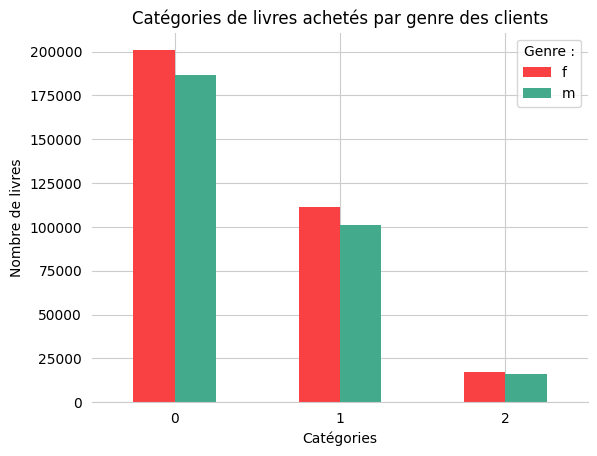

In [61]:
ax = contingency_table.plot.bar(zorder=2, color=['#f94144', '#43aa8b'])

ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xlabel('Catégories')

ax.set_ylabel('Nombre de livres')

ax.legend(title='Genre :')

ax.set_title('Catégories de livres achetés par genre des clients')

plt.show()

del ax

Pour finir, on réalise le test avec les hypothèses du test sont les suivantes :
* H0 : Les variables sont indépendantes si p-value > 5 % ;
* H1 : Les variables ne sont pas indépendantes si p-value < 5 %.

In [62]:
res = stats.chi2_contingency(contingency_table)

print(f'Résultat du test du Chi² :\n>> p-value = {res.pvalue:.2e}')
if res.pvalue > 0.05:
    print(f'   H0 est retenue, les variables sont indépendantes.')
elif res.pvalue < 0.05:
    print(f'   H1 est retenue, les variables ne sont pas indépendantes.')

del res, contingency_table

Résultat du test du Chi² :
>> p-value = 4.08e-05
   H1 est retenue, les variables ne sont pas indépendantes.


L'hypothèse H0 est rejetée, cela signifie que le genre d'un client influe sur les catégories de livres qu'il achète.

### Âge et montant total des achats, fréquence d’achat et taille du panier moyen<a id='3-2'></a>

Cette fois, on cherche à établir s'il existe une relation entre l'âge et différentes variables :
* le montant total des achats ;
* la fréquence d'achat ;
* la taille de panier moyen.

On compare donc à chaque fois **deux variables quantitatives**.

La première étape consiste à préparer un jeu de données contenant les variables nécessaires.

In [63]:
df_tests_age = df_final.loc[~df_final['client_id'].isin(pro_clients_id)]

df_tests_age = (
    df_tests_age
    .groupby(['client_id', 'age'], as_index=False)
    .agg({'price': 'sum', 'session_id': 'nunique'})
)

df_tests_age = df_tests_age.rename(
    columns={'price': 'turnover', 'session_id': 'frequency'})

df_tests_age['avg_basket'] = (df_tests_age['turnover'] 
                              / df_tests_age['frequency'])

df_tests_age.head(3)

,client_id,age,turnover,frequency,avg_basket
0,c_1,68,558.18,33,16.914545
1,c_10,67,1353.60,34,39.811765
2,c_100,31,254.85,5,50.970000


Les noms des variables sont stockés dans une liste pour simplifier les différentes opérations à venir.

In [64]:
variables_test = list(df_tests_age.columns[-3:])

On commence par afficher la matrice de corrélation qui donne un aperçu des corrélations pour toutes les paires de variables possibles.

In [65]:
df_tests_age.corr(numeric_only=True).style.background_gradient(
    axis=None, cmap='viridis_r')

,age,turnover,frequency,avg_basket
age,1.000000,-0.188376,0.164575,-0.616858
turnover,-0.188376,1.000000,0.823156,0.158983
frequency,0.164575,0.823156,1.000000,-0.310375
avg_basket,-0.616858,0.158983,-0.310375,1.000000


En ce qui concerne l'âge, il est à priori corrélé avec chacune des variables, notamment avec le panier moyen. Plus le client est âgé, moins son panier est élevé.<br>
Afin d'affiner notre compréhension des relations, on affiche le diagramme de dispersion de chaque variables avec l'âge. Le diagramme de distribution de ces dernières va également être représenté.

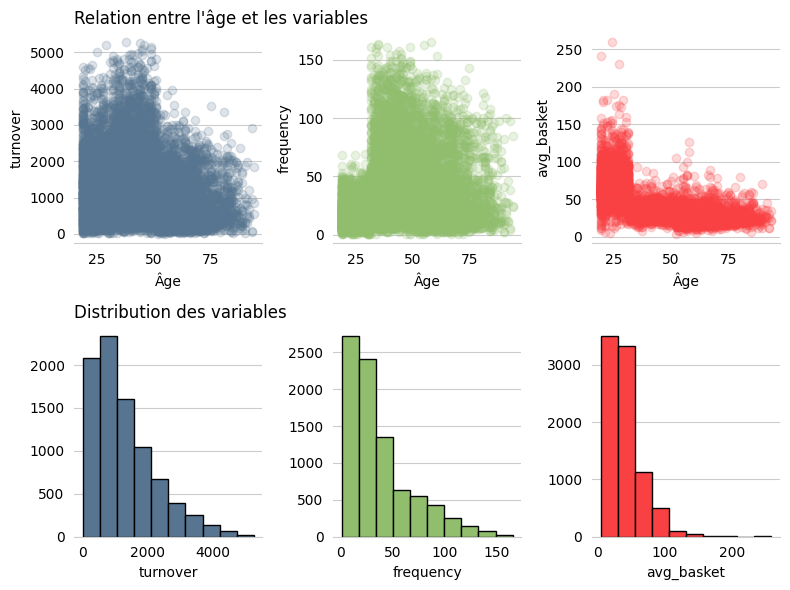

In [66]:
colors = ['#577590', '#90be6d', '#f94144']

fig, axs = plt.subplots(2, 3, figsize=(8, 6))

for j, variable in enumerate(variables_test):
    axs[0][j].scatter('age', variable, data=df_tests_age, alpha=0.2,
                      color=colors[j], zorder=2)
    axs[1][j].hist( df_tests_age[variable], edgecolor='0.0', color=colors[j],
                   zorder=2)
    
    axs[0][j].set_xlabel('Âge')
    axs[0][j].set_ylabel(variable)
    axs[1][j].set_xlabel(variable)

axs[0][0].set_title('Relation entre l\'âge et les variables',
                    size=12, loc='left')
axs[1][0].set_title('Distribution des variables', size=12, loc='left')

plt.tight_layout()
plt.show()

del colors, fig, axs, j, variable

Les graphiques confirment les résultats de la matrice de corrélation et notamment le fait que le lien entre l'âge et le panier moyen soit plus marqué.<br>
Il semble également y avoir une différence de comportement plus marquée chez les clients les plus jeunes en terme de fréquence de visite et de panier moyen.

On passe au test d'indépendance avec les hypothèses suivantes :
* H0 : Les variables sont indépendantes si p-value > 5 % ;
* H1 : Les variables ne sont pas indépendantes si p-value < 5 %.

C'est le test de Pearson qui va être réalisé. C'est un test paramétrique dont les conditions d'application sont respectées :
* les données sont indépendantes ;
* les diagrammes de distribution montrent que la normalité n'est pas respectée mais l'échantillon a une taille supérieure à 30.

In [67]:
print(f'Résultats du test de Pearson :')
for variable in variables_test:
    res = stats.pearsonr(df_tests_age['age'], df_tests_age[variable])
    print(f'- {variable} :\n  >> p-value = {res.pvalue:.2e}')
    if res.pvalue > 0.05:
        print(f'  H0 est retenue, les variables sont indépendantes.\n')
    elif res.pvalue < 0.05:
        print(f'  H1 est retenue, les variables ne sont pas indépendantes.\n')

del df_tests_age, res, variable, variables_test

Résultats du test de Pearson :
- turnover :
  >> p-value = 1.71e-69
  H1 est retenue, les variables ne sont pas indépendantes.

- frequency :
  >> p-value = 2.98e-53
  H1 est retenue, les variables ne sont pas indépendantes.

- avg_basket :
  >> p-value = 0.00e+00
  H1 est retenue, les variables ne sont pas indépendantes.



Le test d'indépendance rejette à chaque fois l'hypothèse H0 et il confirme les observations du tableau de corrélation et des graphiques. On peut dire que l'âge est corrélé avec chacune des variables donc qu'il va avoir une influence sur le comportement des clients.

### Âge des clients et catégories des livres achetés<a id='3-3'></a>

Pour finir, nous allons chercher à établir s'il y a un lien entre l'âge et les catégories des livres achetés par les clients. Le test porte sur **une variable quantitative et une variable qualitative**. L'objectif est de déterminer si chaque catégories de livres est achetée par des clients similaires en âge.<br>
On commence à nouveau par préparer les données nécessaires en calculant le nombre de livres achetés par catégorie et par client.

In [68]:
df_age_category = df_final.loc[~df_final['client_id'].isin(pro_clients_id)]
df_age_category = df_age_category[['category', 'age']]

df_age_category.head(3)

,category,age
0,0,37
1,1,35
3,2,23


Il faut maintenant choisir le test que l'on va utiliser en s'assurant que les conditions d'application seront respectées. On sait déjà que :
* les données sont indépendantes ;
* la normalité des données n'est pas nécessaire étant donné la taille de l'échantillon.

Vérifions l'égalité des variances en représentant nos groupes grâce à des boîtes à moustaches. La taille de ces dernières va nous permettre de visualiser graphiquement les variances.

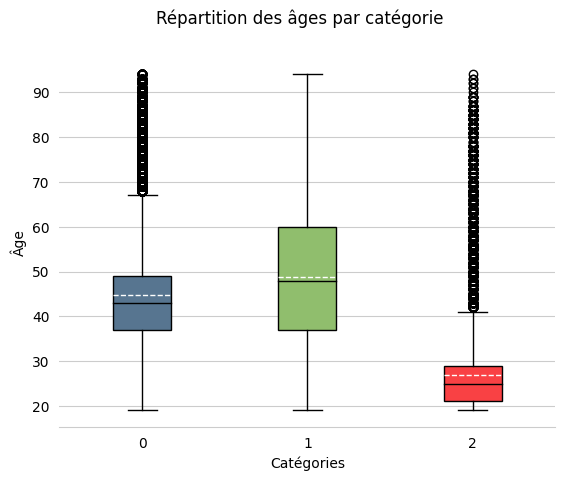

In [69]:
categories = df_age_category['category'].unique()
colors = ['#577590', '#90be6d', '#f94144']

fig, ax = plt.subplots()

for i, category in enumerate(categories):
    df = df_age_category.loc[df_age_category['category'] == category]
    ax.boxplot(df['age'], positions=[i], zorder=2, widths=0.35,
               showfliers=True, patch_artist=True, showmeans=True,
               meanline=True, boxprops=dict(facecolor=colors[i]),
               medianprops=dict(color='0.0'), meanprops=dict(color='1.0'))

ax.set_xlabel('Catégories')
ax.set_ylabel('Âge')

fig.suptitle('Répartition des âges par catégorie')

plt.show()

del categories, colors, fig, ax, i, df, category

Les variances ne semblent pas égales. Confirmons cela grâce au test de Barlett avec les hypothèses suivantes :
* H0 : les variances de chaque groupe sont égales si p-value > 5 % ;
* H1 : les variances de chaque groupe ne sont pas égales si p-value < 5 %.

In [70]:
res = stats.bartlett(
    df_age_category.loc[df_age_category['category'] == 0, 'age'],
    df_age_category.loc[df_age_category['category'] == 1, 'age'],
    df_age_category.loc[df_age_category['category'] == 2, 'age']
)

print(f'Résultats du test de Bartlett :\n>> p-value = {res.pvalue:.2e}')
if res.pvalue > 0.05:
    print(f'   H0 est retenue, les variances des groupes sont égales.')
elif res.pvalue < 0.05:
    print(f'   H1 est retenue, les variances des groupes ne sont pas égales.')

del res

Résultats du test de Bartlett :
>> p-value = 0.00e+00
   H1 est retenue, les variances des groupes ne sont pas égales.


Le résultat du test indique que les variances ne sont pas égales. Les conditions d'un test ANOVA ne sont pas respectées, on choisit donc le test de Kruskal-Wallis (non paramétrique) qui va tester si les médianes des groupes sont significativement différentes.<br>
Hypothèses (chaque groupe correspond à une catégorie de livre) :
* H0 : Les médianes de chaque groupe sont égales si p-value > 5 % ;
* H1 : Les médianes de chaque groupe ne sont pas toutes égales si p-value < 5 %.

In [71]:
res = stats.kruskal(
    df_age_category.loc[df_age_category['category'] == 0, 'age'],
    df_age_category.loc[df_age_category['category'] == 1, 'age'],
    df_age_category.loc[df_age_category['category'] == 2, 'age']
)

print(f'Résultat du test Kruskal-Wallis :\n>> p-value = {res.pvalue:.2e}')
if res.pvalue > 0.05:
    print(f'   H0 est retenue, les médianes de chaque groupe sont égales.')
elif res.pvalue < 0.05:
    print(f'   H1 est retenue, les médianes de chaque groupe ne sont pas égales.')

del res

Résultat du test Kruskal-Wallis :
>> p-value = 0.00e+00
   H1 est retenue, les médianes de chaque groupe ne sont pas égales.


Pour aller plus loin, voyons si le résultat du test ANOVA aurait été différent.<br>
Hypothèses (chaque groupe correspond à une catégorie de livre) :
* H0 : Les moyennes de chaque groupe sont égales si p-value > 5 % ;
* H1 : Les moyennes de chaque groupe ne sont pas toutes égales si p-value < 5 %.

In [72]:
res = stats.f_oneway(
    df_age_category.loc[df_age_category['category'] == 0, 'age'],
    df_age_category.loc[df_age_category['category'] == 1, 'age'],
    df_age_category.loc[df_age_category['category'] == 2, 'age']
)

print(f'Résultat du test ANOVA :\n>> p-value = {res.pvalue:.2e}')
if res.pvalue > 0.05:
    print(f'   H0 est retenue, les moyennes de chaque groupe sont égales.')
elif res.pvalue < 0.05:
    print(f'   H1 est retenue, les moyennes de chaque groupe ne sont pas égales.')

del res, df_age_category

Résultat du test ANOVA :
>> p-value = 0.00e+00
   H1 est retenue, les moyennes de chaque groupe ne sont pas égales.


Les deux tests montrent le même résultat. L'âge impacte les catégories des livres achetés.